In [1]:
from keras.applications import MobileNet
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


img_rows, img_cols = 224, 224

MobileNet = MobileNet(weights = 'imagenet',
                     include_top = False,
                     input_shape = (img_rows, img_cols, 3),
                     alpha=0.25
                     )

for layer in MobileNet.layers:
    layer.trainable = False

In [2]:
def addTopModelMobileNet(bottom_model, num_classes):
    
    top_model = bottom_model.output
    top_model = BatchNormalization()(top_model)
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(64,activation = 'relu')(top_model)
    top_model = Dropout(0.25)(top_model)
    top_model = Dense(32, activation = 'relu')(top_model)
    top_model = Dense(num_classes, activation = 'softmax')(top_model)
    
    return top_model
    

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l1, l2

num_classes = 3

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 8)       216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 8)       32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 8)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 8)       72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 8)      

In [4]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = './data/train'
test_dir = './data/test'

In [5]:
datagen = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1./255,
    rotation_range = 45
    
    #width_shift_range = 0.3,
    #height_shift_range = 0.3,
    #horizontal_flip = False,
    #fill_mode = 'nearest'
)


batch_size = 16

train_generator = datagen.flow_from_directory(
    data_dir,
    subset ='training',
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    subset = 'validation',
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_datagen = ImageDataGenerator( rescale = 1./255 )

test_batches = test_datagen.flow_from_directory(test_dir, 
                                                target_size=(img_rows,img_cols),
                                                shuffle = False
                                               )
                                                                                             

Found 204 images belonging to 3 classes.
Found 51 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [6]:
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import categorical_crossentropy

checkpoint = ModelCheckpoint("./model/tea.h5",
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1
                            )

earlystop = EarlyStopping(monitor = "val_loss",
                         min_delta = 0,
                         patience = 5,
                         verbose = 1,
                         restore_best_weights = True
                         )

callbacks = [earlystop, checkpoint]

model.compile(loss = 'categorical_crossentropy',
              optimizer = Nadam(lr = 0.001, beta_1 = 0.99, beta_2 = 0.999, epsilon = 1e-07),
              metrics = ['accuracy']
             )

In [7]:
nb_train_samples = 204
nb_validation_samples = 51

epochs = 50
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size,
    shuffle = True
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.0769 - accuracy: 0.3883
Epoch 00001: val_loss improved from inf to 1.02711, saving model to ./model\tea.h5
12/12 [==============================] - 7s 543ms/step - loss: 1.0769 - accuracy: 0.3883 - val_loss: 1.0271 - val_accuracy: 0.5000
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.9473 - accuracy: 0.5266
Epoch 00002: val_loss improved from 1.02711 to 0.82984, saving model to ./model\tea.h5
12/12 [==============================] - 7s 551ms/step - loss: 0.9473 - accuracy: 0.5266 - val_loss: 0.8298 - val_accuracy: 0.6875
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.7917 - accuracy: 0.7074
Epoch 00003: val_loss improved from 0.82984 to 0.66828, saving model to ./model\tea.h5
12/12 [==============================] - 7s 543ms/step - loss: 0.7917 - accuracy: 0.7074 - val_loss: 0.6683 - val_accuracy:

In [8]:
test_labels = test_batches.classes

In [9]:
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [10]:
test_batches.class_indices

{'blight': 0, 'red_scab': 1, 'red_spot': 2}

In [11]:
import itertools

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
from keras.models import load_model

classifier = load_model('./model/tea.h5')

predictions = classifier.predict_generator(test_batches, steps=1, verbose=1)


Instructions for updating:
Please use Model.predict, which supports generators.
1/1 [==============================] - 0s 3ms/step


In [14]:

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[5 0 0]
 [0 5 0]
 [0 0 5]]


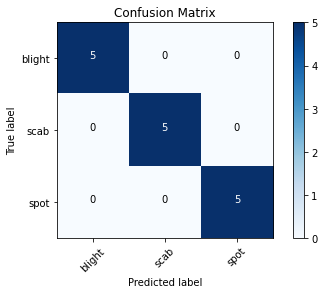

In [15]:
cm_plot_labels = ['blight', 'scab', 'spot']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

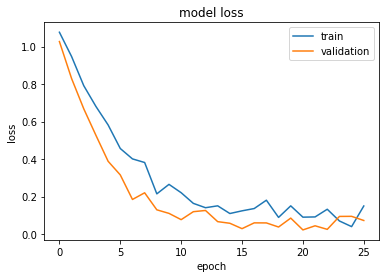

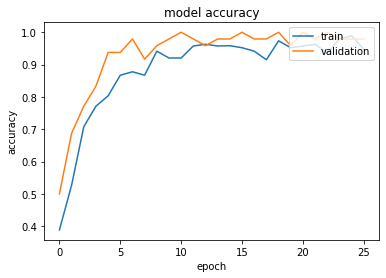

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [17]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
model_2 =Sequential([hub.KerasLayer(url,
                                    output_shape=[1280],
                                    trainable=False
                                   ),
                     Dropout(0.4),
                     Dense(num_classes, activation='softmax')
])

input_shape=[None, 224, 224, 3]

model_2.build(input_shape)
learning_rate = 0.0001

model_2.summary()

model_2.compile(

    optimizer=SGD(lr = 0.001, momentum = 0.8 , nesterov = True),

    loss='categorical_crossentropy',

    metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
checkpoint = ModelCheckpoint("./model/tea_sequential.h5",
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1
                            )

earlystop = EarlyStopping(monitor = "val_loss",
                         min_delta = 0,
                         patience = 5,
                         verbose = 1,
                         restore_best_weights = True
                         )

callbacks = [earlystop, checkpoint]

In [19]:

hist = model_2.fit(
    train_generator,
    epochs=50,
    verbose=1,
    callbacks = callbacks,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

hist = hist.history

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.3408 - acc: 0.4043
Epoch 00001: val_loss improved from inf to 0.64271, saving model to ./model\tea_sequential.h5
12/12 [==============================] - 11s 919ms/step - loss: 1.3408 - acc: 0.4043 - val_loss: 0.6427 - val_acc: 0.7292
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.7054 - acc: 0.6968
Epoch 00002: val_loss improved from 0.64271 to 0.31873, saving model to ./model\tea_sequential.h5
12/12 [==============================] - 10s 851ms/step - loss: 0.7054 - acc: 0.6968 - val_loss: 0.3187 - val_acc: 0.9167
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.4250 - acc: 0.8298
Epoch 00003: val_loss improved from 0.31873 to 0.22397, saving model to ./model\tea_sequential.h5
12/12 [==============================] - 11s 907ms/step - loss: 0.4250 - acc: 0.8298 - val_loss: 0.2240 - val_acc: 0.9375
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.3222 - 

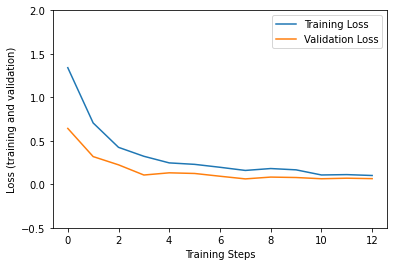

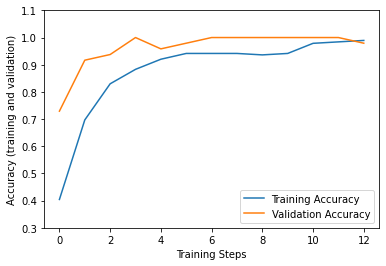

In [20]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([-0.5,2])
plt.plot(hist["loss"],label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')


plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0.3,1.1])
plt.plot(hist["acc"],label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend(loc='lower right')